In [109]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# modelling
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, make_scorer, calinski_harabasz_score

# import a bunch of clustering models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [32]:
df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',
                 index_col=False)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_44048/2769116822.py:1: DtypeWarning: Columns (1,2,3,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',


In [33]:
df.shape

(71787, 124)

In [34]:
df.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR,case_id,faa_digital_obstacle_id,faa_obstruction_evaluation_id,usgs_id,eia_id,state,county,state_county_id,project_name,operational_year,project_turbine_num,cumulative_capacity (MW),manufacturer,model_name,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),retrofit (y/n),retrofit_year,attribute_confidence_level (1/2/3),location_confidence_level (1/2/3),location_verification_date,image_source,xlong,ylat
0,1.0,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.051,13.182,7.49,13.764,0.0,0.0,1184.0,1184.0,134.0,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90.0,N,.,Snake River,Nome Joint Utility Systems,13642.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0.0,0.0,18837.0,18837.0,2130.0,2021.0,3032513.0,02-020068,2009-WTW-1520-OE,1900.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrity,EW50,50.0,31.1,15.0,176.71,38.6,0.0,NaN,3.0,3.0,9/30/2019,Digital Globe,-165.426483,64.571999
2,90.0,N,.,Snake River,Nome Joint Utility Systems,13642.0,AK,PACN,NaN,NaN,22.0,1.0,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0.0,0.0,18837.0,18837.0,2130.0,2021.0,3032511.0,02-020066,2009-WTW-1518-OE,1898.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrit

## Missing Model Specs 

In [35]:
df.isnull().sum()

Plant Id                                7248
Combined Heat And\nPower Plant          7248
Nuclear Unit Id                         7248
Plant Name                              7248
Operator Name                           7248
Operator Id                             7248
Plant State                             7248
Census Region                           7248
NERC Region                             7444
Reserved                               71787
NAICS Code                              7248
EIA Sector Number                       7248
Sector Name                             7248
Reported\nPrime Mover                   7248
Reported\nFuel Type Code                7248
AER\nFuel Type Code                     7248
Balancing\nAuthority Code               7435
Respondent\nFrequency                   7250
Physical\nUnit Label                   71787
Quantity\nJanuary                       7248
Quantity\nFebruary                      7248
Quantity\nMarch                         7248
Quantity\n

In [36]:
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects before removing null values')

we have 1726 unique projects before removing null values


### Missing Generation Data

In [37]:
# remove 0 values for net generation because they are probably not operational
missing_values = df[df['Net Generation\n(Megawatthours)'] == 0]['project_name'].nunique()
print(missing_values)

15


In [38]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[df['Net Generation\n(Megawatthours)'] != 0]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 0.87% of the data
we have 1711 unique projects after removing null values


### Missing Model Names

In [39]:
missing_values = df[df.model_name.isnull()]['project_name'].nunique()
print(missing_values)

213


In [40]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[~df.model_name.isnull()]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 12.45% of the data
we have 1504 unique projects after removing null values


### Turbine Capacity

In [41]:
missing_values=df[df['turbine_capacity (KW)'].isnull()]['project_name'].nunique()
print(missing_values)

2


In [42]:
print(f'we are dropping {(missing_values/unique_projects)*100:.2f}% of the data')
df = df[~df['turbine_capacity (KW)'].isnull()]
unique_projects = df['project_name'].nunique()
print(f'we have {unique_projects} unique projects after removing null values')

we are dropping 0.13% of the data
we have 1503 unique projects after removing null values


## Model

In [43]:
# check that there are no missing values
missing_values=df[df['project_turbine_num'].isnull()]['project_name'].nunique()
print(missing_values)

0


In [44]:
# are the columns the same?
a = df['Elec Fuel Consumption\nMMBtu'] == df['Total Fuel Consumption\nMMBtu']
# assert all of the a.value_counts() are true
assert all(a.value_counts())==True, 'The columns are not the same'

In [45]:
df.isnull().sum()

Plant Id                                3532
Combined Heat And\nPower Plant          3532
Nuclear Unit Id                         3532
Plant Name                              3532
Operator Name                           3532
Operator Id                             3532
Plant State                             3532
Census Region                           3532
NERC Region                             3702
Reserved                               66488
NAICS Code                              3532
EIA Sector Number                       3532
Sector Name                             3532
Reported\nPrime Mover                   3532
Reported\nFuel Type Code                3532
AER\nFuel Type Code                     3532
Balancing\nAuthority Code               3702
Respondent\nFrequency                   3532
Physical\nUnit Label                   66488
Quantity\nJanuary                       3532
Quantity\nFebruary                      3532
Quantity\nMarch                         3532
Quantity\n

In [46]:
# group by turbine_capacity (KW) and project_name
model_df = df.groupby(['project_name'
                    #    'Plant State',
                    #    'Census Region',
                    #    'NERC Region',
                    #    'county'
                       ]).agg(
    {'turbine_capacity (KW)':'sum',
        'Net Generation\n(Megawatthours)':'mean',
        'Total Fuel Consumption\nMMBtu':'mean',
        'hub_height (m)':'mean',
        'rotor_diameter (m)':'mean',
        'rotor_swept area (m2)':'mean',
        'max_height (m)':'mean',
        })


In [47]:
model_df.shape

(1503, 7)

In [48]:
# reset index and keep the column of model_df
model_df = model_df.reset_index()

In [49]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   project_name                    1503 non-null   object 
 1   turbine_capacity (KW)           1503 non-null   float64
 2   Net Generation
(Megawatthours)  1218 non-null   float64
 3   Total Fuel Consumption
MMBtu    1218 non-null   float64
 4   hub_height (m)                  1454 non-null   float64
 5   rotor_diameter (m)              1467 non-null   float64
 6   rotor_swept area (m2)           1467 non-null   float64
 7   max_height (m)                  1454 non-null   float64
dtypes: float64(7), object(1)
memory usage: 94.1+ KB


In [50]:
# drop all null values
model_df = model_df.dropna()

In [51]:
len(model_df)

1206

## Numerical Features

In [54]:
model_df.describe()

,turbine_capacity (KW),Net Generation\n(Megawatthours),Total Fuel Consumption\nMMBtu,hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m)
count,1206.000000,1.206000e+03,1.206000e+03,1206.000000,1206.000000,1206.000000,1206.000000
mean,104078.340796,3.554249e+05,3.143378e+06,80.862242,93.722466,7278.509662,127.748990
std,94808.077489,3.675602e+05,3.250702e+06,10.979419,21.784328,3183.364269,20.519811
min,195.000000,5.400000e+01,4.780000e+02,22.800000,15.000000,176.710000,31.100000
25%,20550.000000,6.235925e+04,5.515040e+05,80.000000,82.000000,5281.020000,119.814000
50%,89980.000000,2.635950e+05,2.331234e+06,80.000000,91.000000,6539.715000,126.200000
75%,160650.000000,5.415659e+05,4.789610e+06,85.000000,110.000000,9503.320000,139.360516
max,559700.000000,2.313973e+06,2.046478e+07,125.960000,155.000000,18869.190000,194.560000


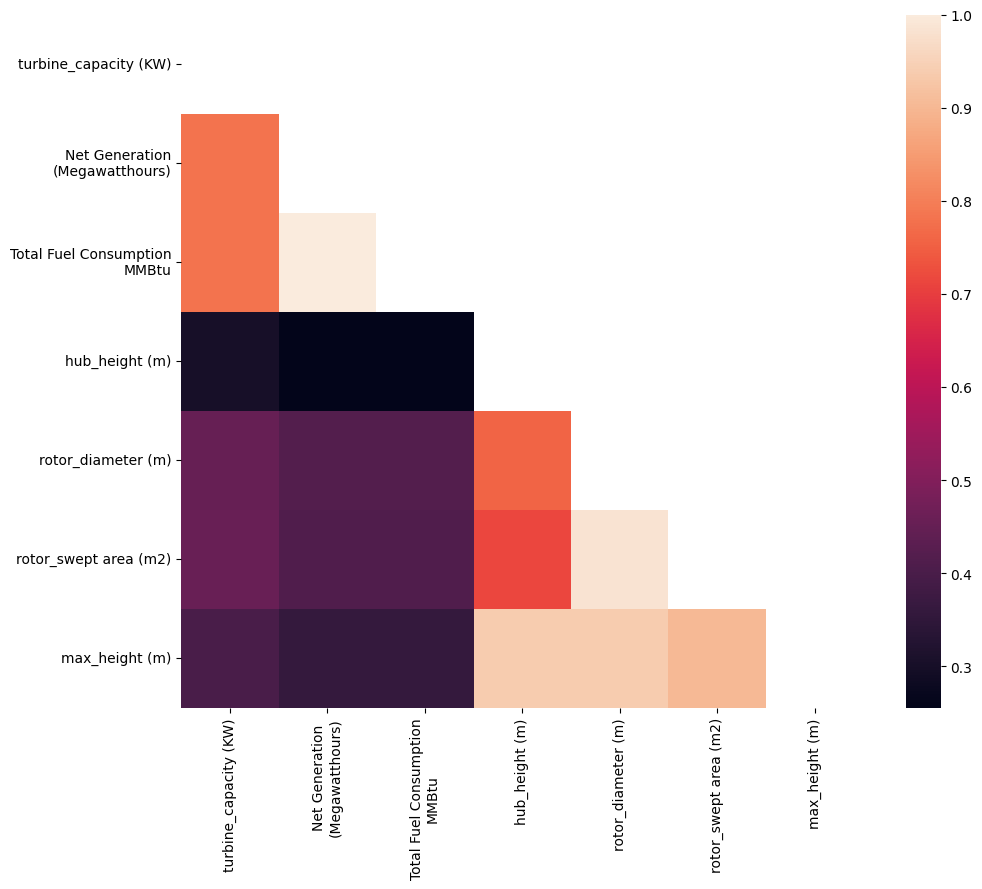

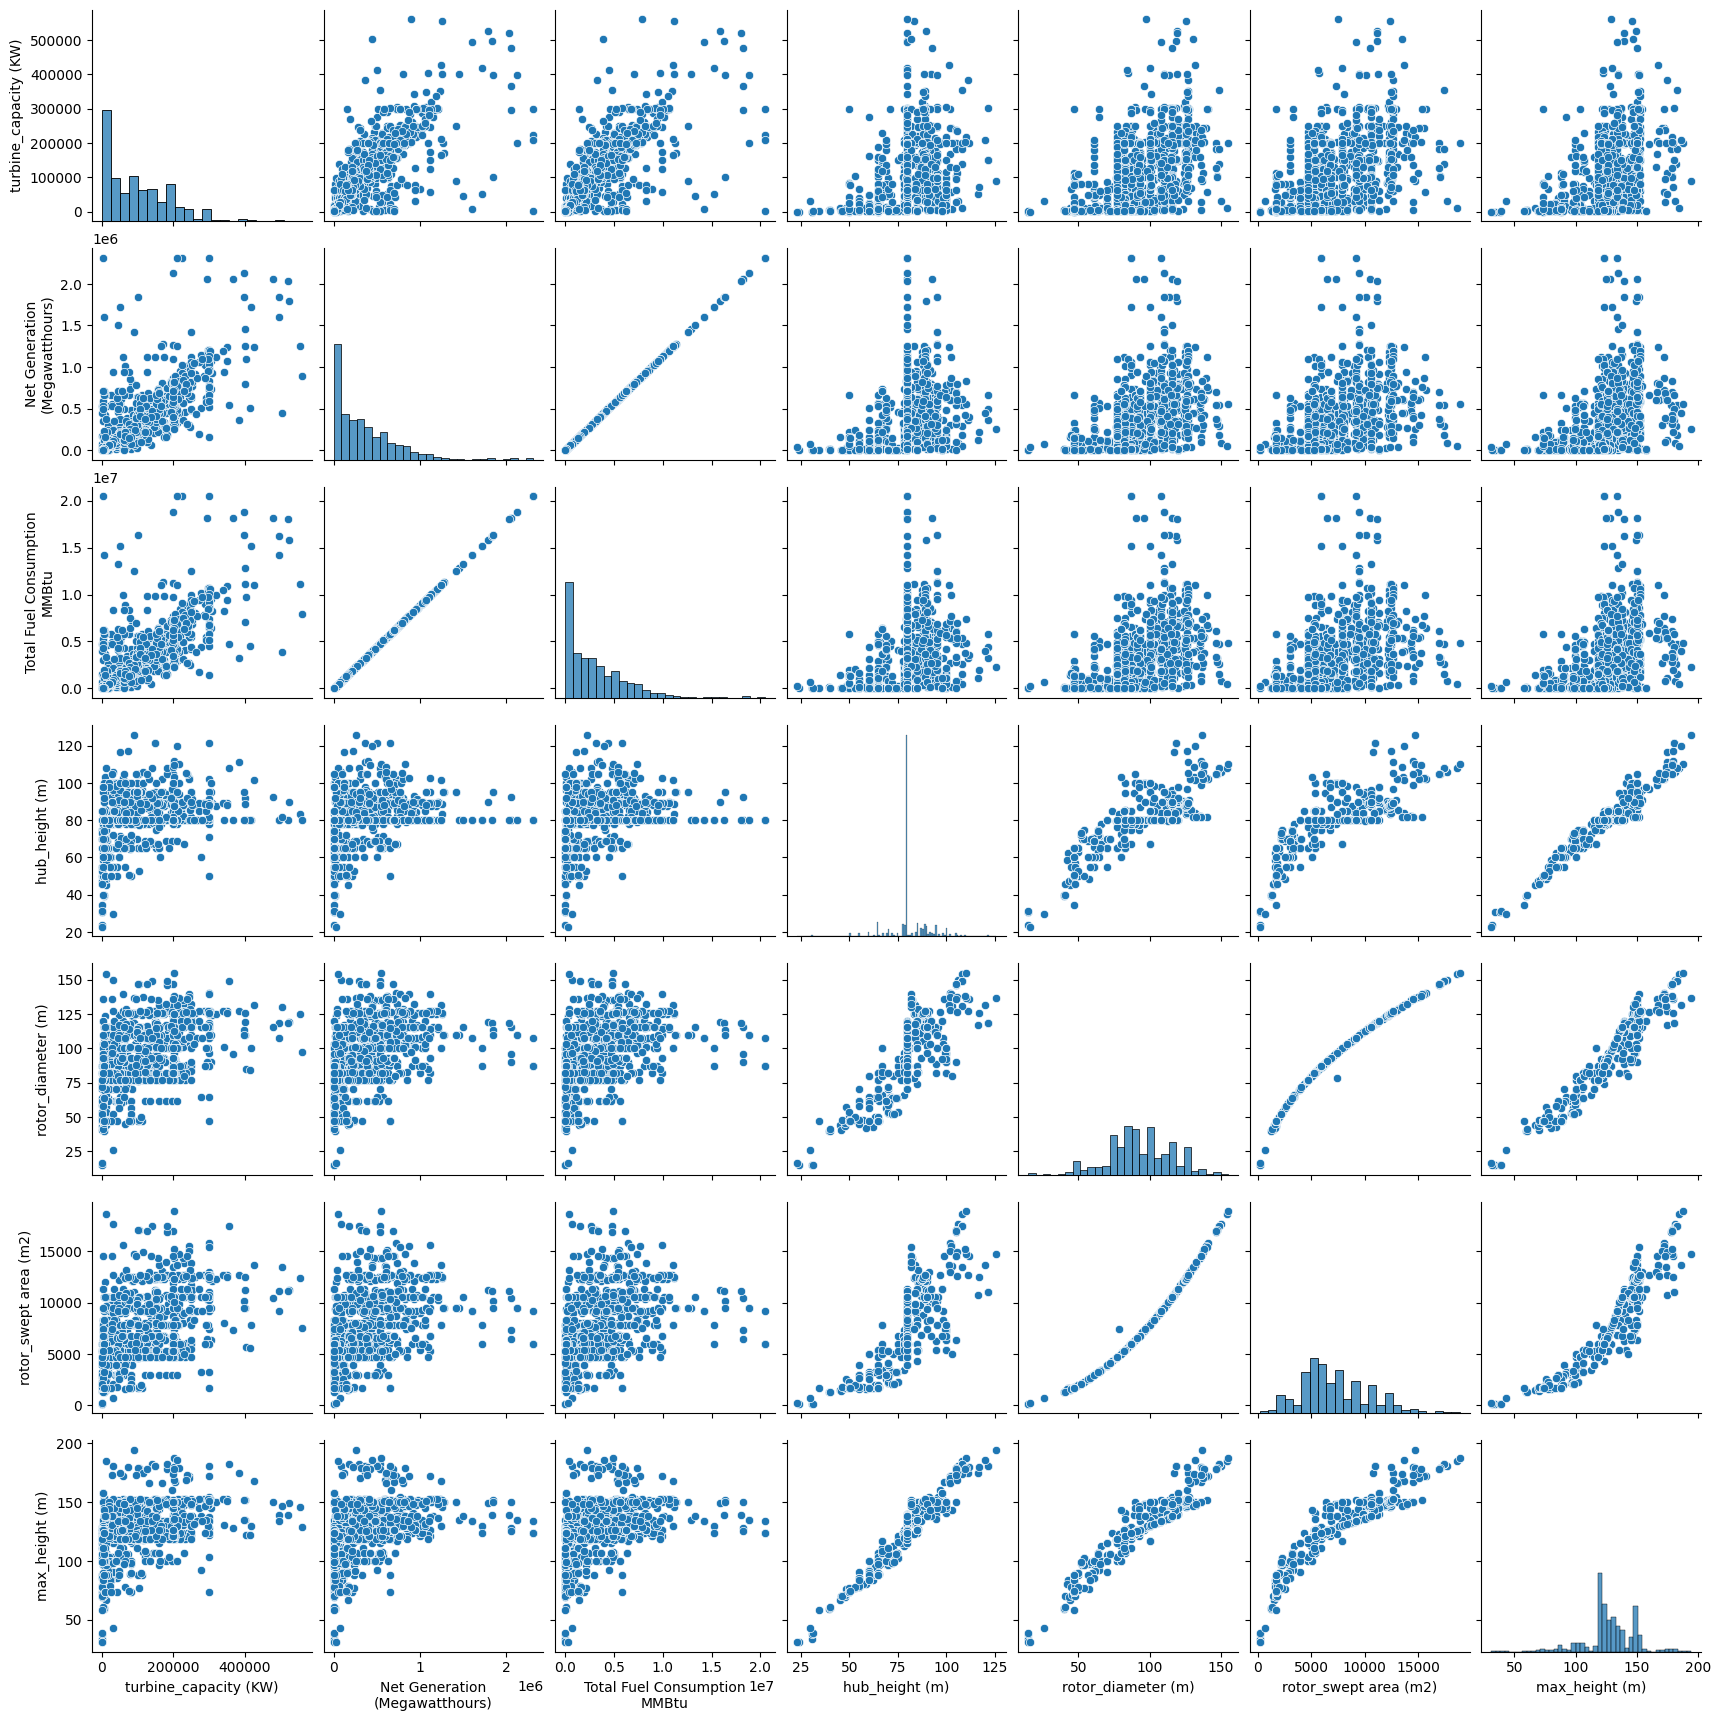

In [66]:
# plot a correlation matrix
import seaborn as sns
corr = model_df.corr(numeric_only=True)

# show only half the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask)

# plot a pairplot
sns.pairplot(model_df)

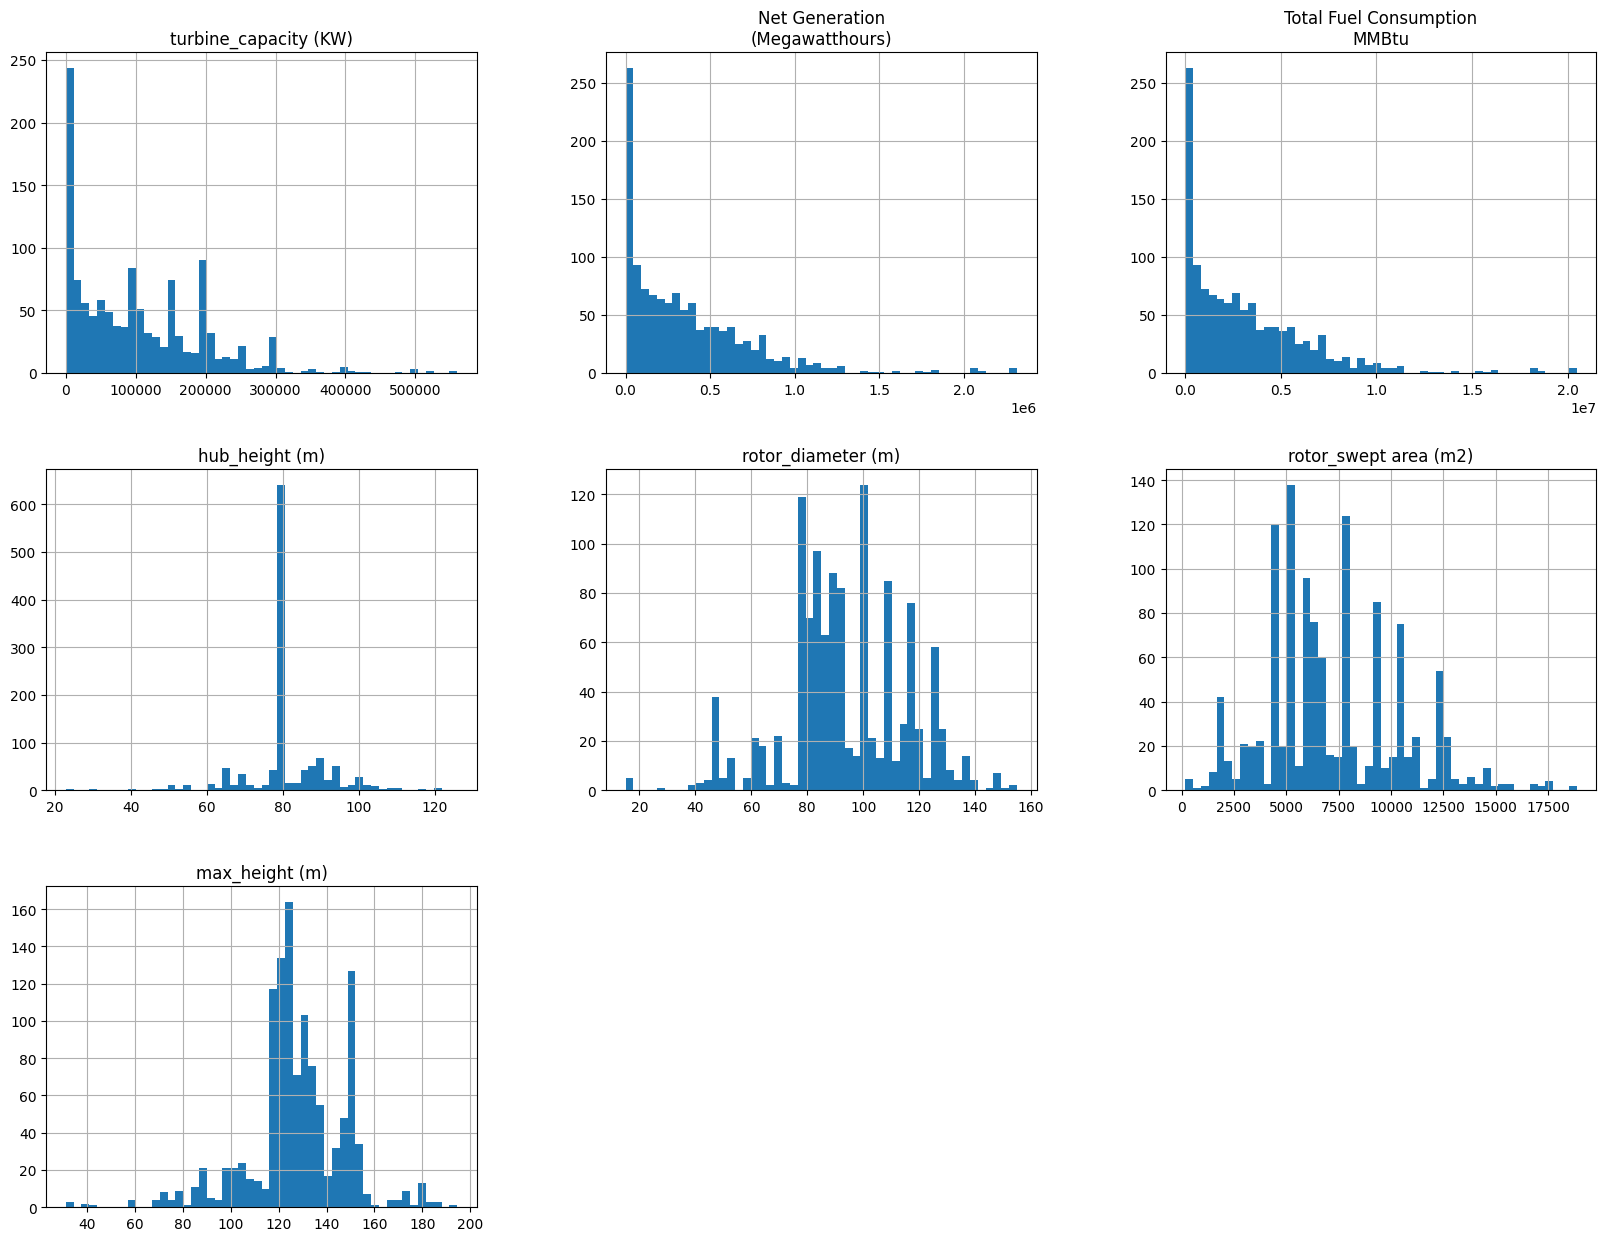

In [67]:
# plot histogram for each numerical feature
model_df.hist(bins=50, figsize=(20,15))
plt.show()

## Pipeline

In [78]:
X = model_df.drop(['project_name'], axis=1)

In [79]:
# setup the ordinal features
# ordinal_features = ['education']
# order = [['basic.4y', 'basic.6y','basic.9y', 'high.school','professional.course','university.degree']]

# setup the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# for idp_var in ordinal_features:
    # while idp_var in categorical_features:
        # categorical_features.remove(idp_var)

In [80]:
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',StandardScaler(),numerical_features),
    # ('tnf2',OrdinalEncoder(categories=order),ordinal_features),
    ('tnf3',OneHotEncoder(),categorical_features)
# ])
], remainder='passthrough')

In [116]:
models = [
        ('KM', KMeans()),
        ('AC', AgglomerativeClustering()),
        ('BIR', Birch()),
        ('MBKM', MiniBatchKMeans()),
        ('OPT', OPTICS()),
        ('SC', SpectralClustering())
        # ('MS', MeanShift()),
        # ('DB', DBSCAN()),
        # ('AP', AffinityPropagation())
        ]

running KM with KMeans()


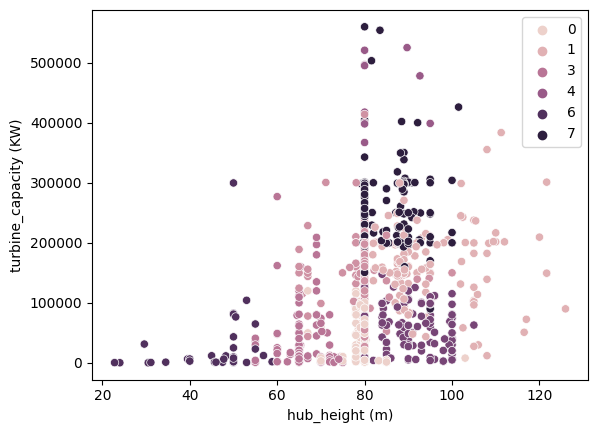

running AC with AgglomerativeClustering()


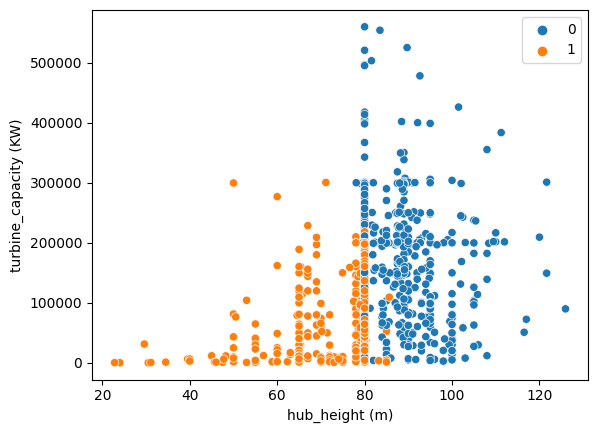

running BIR with Birch()


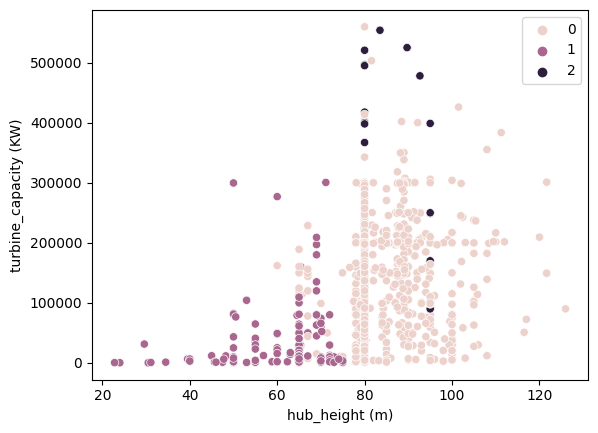

running MBKM with MiniBatchKMeans()


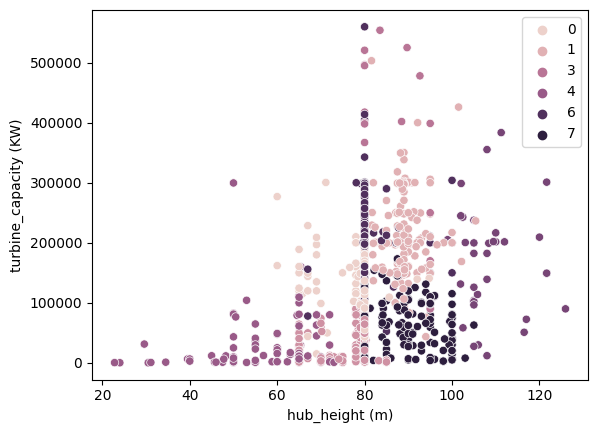

running OPT with OPTICS()


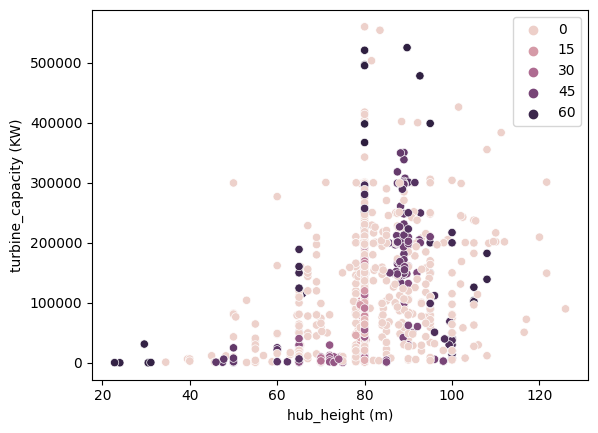

running SC with SpectralClustering()


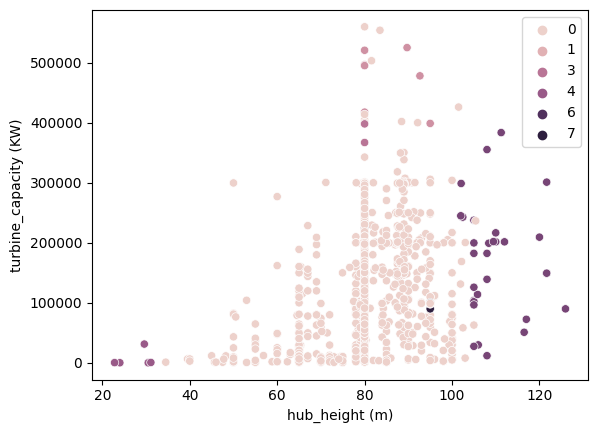

In [125]:
model_name = []
model_score = []
clusters = [2,3,4,5,6,7,8,9,10]

# optimize clusters for unknown data labels

for name, model in models:
    # for i in clusters:
        n_model = model
        # model_name.append(n_model) 

        print(f'running {name} with {model}')        
        pipeline = Pipeline([('preprocessor', preprocessor), ('clusterer', n_model)])
        pipeline.fit(X)
        sns.scatterplot(data = X, x = 'hub_height (m)', y = 'turbine_capacity (KW)', hue = n_model.labels_)
        plt.show()

In [111]:
print(names)
print(scorers)
print(results)

['KM', 'AC', 'BIR', 'MBKM', 'MS', 'OPT', 'SC', 'AP']
[]
[]
